# validation_analysis
Contains some usefull scripts to:
    1) merge all validation results of a model over multiple runs into a single csv-file
        a) including mean, median, stddev, etc.
    2) plot these results, including confidence intervals

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt
import os

In [15]:
# This cell contains stuff you should change per run:
results_dir = "/home/vincent/Documenten/BachelorsProject/ft_artist/"
target_dir = "/home/vincent/Documenten/BachelorsProject/GitHub_Repo/results/ft_artist/"

# Contains everything we need per model
models = {
    "vit_b_16": {"vit": True},
    "swin_b": {"vit": True},
    "beit_b_16": {"vit": True},
    "deit_b_16": {"vit": True},
    "vgg19": {"vit": False},
    "resnet50": {"vit": False},
    "efficientnetv2_m": {"vit": False},
    "convnext_b": {"vit": False}
}

In [16]:
# Initializing a list to store all corresponding validation dataframes in:
for model in models:
    models[model]["dfs"] = []

# Getting all csvs corresponding to the different models
for file in os.scandir(results_dir):
    if file.is_file() and "validation.csv" in file.name:
        for model in models:
            if model in file.name:
                models[model]["dfs"] += [file.path]

# Sorting the paths and turning them into dataframes
for model in models:
    models[model]["dfs"].sort()
    models[model]["dfs"] = [pd.read_csv(p) for p in models[model]["dfs"]]

In [17]:
# Merges all individual validation dataframes of a given model into one
# Also includes aggregation statistics, such as mean, median, etc
def mergeDfs(dfs: list):
    """Returns a df containing all losses and accuracies, and aggregation statistics about these"""
    d_loss = {}
    d_acc = {}
    # Get max length so we can pad the rest with NaN-values:
    length = max([len(x) for x in dfs])
    for idx, df in enumerate(dfs):
        d_loss[f"loss{idx}"] = df["mean_loss"].to_list() + [float('nan')] * (length - len(df))
        d_acc[f"accuracy{idx}"] = df["accuracy"].to_list() + [float('nan')] * (length - len(df))
    fdfs = {
        "loss": pd.DataFrame(d_loss),
        "acc": pd.DataFrame(d_acc)
    }
    
    # Adding a bunch of aggregation statistics to the dfs:
    for stat in fdfs:
        mean = fdfs[stat].mean(axis=1, skipna=False)
        std = fdfs[stat].std(axis=1, skipna=False)
        low_bound = mean - std / sqrt(len(fdfs[stat].columns))
        up_bound = mean + std / sqrt(len(fdfs[stat].columns))
        median = fdfs[stat].median(axis=1, skipna=False)
        q1 = fdfs[stat].quantile(0.25, axis=1)
        q3 = fdfs[stat].quantile(0.75, axis=1)

        fdfs[stat][f"mean_{stat}"] = mean
        fdfs[stat][f"std_{stat}"] = std
        fdfs[stat][f"low_bound_{stat}"] = low_bound
        fdfs[stat][f"up_bound_{stat}"] = up_bound
        fdfs[stat][f"median_{stat}"] = median
        fdfs[stat][f"q1_{stat}"] = q1
        fdfs[stat][f"q3_{stat}"] = q3
    return pd.concat([fdfs["loss"], fdfs["acc"]], axis=1)

for model in models:
    models[model]["df"] = mergeDfs(models[model]["dfs"])

In [18]:
# Saving the csv-files:
for model in models:
    models[model]["df"].to_csv(os.path.join(target_dir, f"{model}_val.csv"), index=False)

## Now comes the actual plotting! :-D

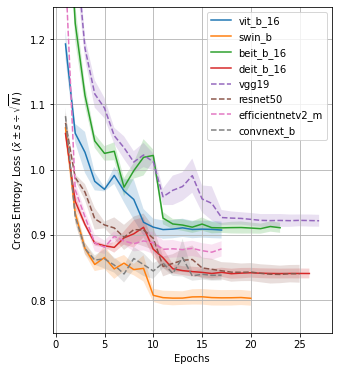

In [19]:
# Plotting mean loss
for model in models:
    df = models[model]["df"]
    x = [idx + 1 for idx in range(len(df))]
    y = df["mean_loss"].to_list()
    ybott = df["low_bound_loss"].to_list()
    ytop = df["up_bound_loss"].to_list()
    ls = "-" if models[model]["vit"] else "--"
    plt.plot(x, y, label=model, linestyle=ls)
    plt.fill_between(x, y1=ybott, y2=ytop, alpha=0.2)

plt.legend()
plt.grid()
plt.xlabel("Epochs")
plt.ylabel(r"Cross Entropy Loss ($\bar{x} \pm s \div \sqrt{N}$)")
plt.ylim(top=1.25)

fig = plt.gcf()
fig.set_size_inches(5, 6)
plt.savefig(os.path.join(target_dir, "mean_loss.svg"), format="svg")
#plt.show()

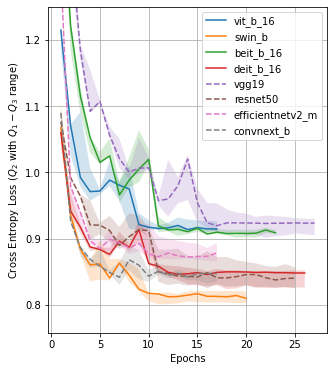

In [20]:
# Plotting median loss
for model in models:
    df = models[model]["df"]
    x = [idx + 1 for idx in range(len(df))]
    y = df["median_loss"].to_list()

    # Doing 0 times median because want to get NaN if median gets NaN
    ybott = (df["q1_loss"] + 0 * df["median_loss"]).to_list()
    ytop = (df["q3_loss"] + 0 * df["median_loss"]).to_list()
    ls = "-" if models[model]["vit"] else "--"
    plt.plot(x, y, label=model, linestyle=ls)
    plt.fill_between(x, y1=ybott, y2=ytop, alpha=0.2)

plt.legend()
plt.grid()
plt.xlabel("Epochs")
plt.ylabel(r"Cross Entropy Loss ($Q_2$ with $Q_1 - Q_3$ range)")
plt.ylim(top=1.25)

fig = plt.gcf()
fig.set_size_inches(5, 6)
plt.savefig(os.path.join(target_dir, "median_loss.svg"), format="svg")
#plt.show()

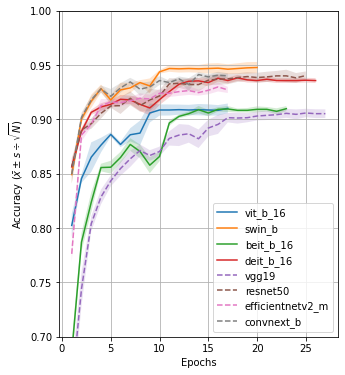

In [23]:
# Plotting mean accuracy
for model in models:
    df = models[model]["df"]
    x = [idx + 1 for idx in range(len(df))]
    y = df["mean_acc"].to_list()
    ybott = df["low_bound_acc"].to_list()
    ytop = df["up_bound_acc"].to_list()
    ls = "-" if models[model]["vit"] else "--"
    plt.plot(x, y, label=model, linestyle=ls)
    plt.fill_between(x, y1=ybott, y2=ytop, alpha=0.2)

plt.legend()
plt.grid()
plt.xlabel("Epochs")
plt.ylabel(r"Accuracy ($\bar{x} \pm s \div \sqrt{N}$)")
plt.ylim(top=1, bottom=0.7)

fig = plt.gcf()
fig.set_size_inches(5, 6)
plt.savefig(os.path.join(target_dir, "mean_accuracy.svg"), format="svg")
#plt.show()

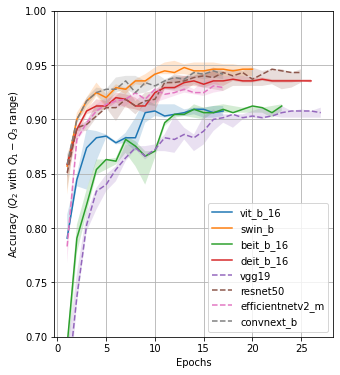

In [24]:
# Plotting median accuracy
for model in models:
    df = models[model]["df"]
    x = [idx + 1 for idx in range(len(df))]
    y = df["median_acc"].to_list()

    # Doing 0 times median because want to get NaN if median gets NaN
    ybott = (df["q1_acc"] + 0 * df["median_acc"]).to_list()
    ytop = (df["q3_acc"] + 0 * df["median_acc"]).to_list()
    ls = "-" if models[model]["vit"] else "--"
    plt.plot(x, y, label=model, linestyle=ls)
    plt.fill_between(x, y1=ybott, y2=ytop, alpha=0.2)

plt.legend()
plt.grid()
plt.xlabel("Epochs")
plt.ylabel(r"Accuracy ($Q_2$ with $Q_1 - Q_3$ range)")
plt.ylim(top=1, bottom=0.7)

fig = plt.gcf()
fig.set_size_inches(5, 6)
plt.savefig(os.path.join(target_dir, "median_accuracy.svg"), format="svg")
#plt.show()